Objective
- To replcilate a bootstrapping process, and estimate coefficient t-test p-values from memory

plan
- bootstrap
- fit lreg model onto boostrapped sample
- calculate the coefficients
- calculate ceofficient STDV
- run t-test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [2]:
df = pd.read_csv("Advertising.csv")

In [3]:
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
# Normalize

x_cols = df.columns.drop('Sales')
scaler = MinMaxScaler()
df[x_cols] = scaler.fit_transform(df[x_cols])

In [5]:
df.drop(['Sales', 'TV'], axis=1)

,Radio,Newspaper
0,0.762097,0.605981
1,0.792339,0.394019
2,0.925403,0.606860
3,0.832661,0.511873
4,0.217742,0.510994
...,...,...
195,0.074597,0.118734
196,0.098790,0.068602
197,0.187500,0.053650
198,0.846774,0.579595


In [6]:
# create loop to boostrap

boostrap_num = 1000

coef_dist = []

for i in range(boostrap_num):

    # bootstrap sample
    df_new = df.sample(frac = 1, replace=True)

    # fit lreg
    X = df_new.drop(["Sales"], axis=1)
    y = df_new['Sales']
    lreg = LinearRegression().fit(X, y)

    # get coefficients from lreg

    coef_dist.append(lreg.coef_)

coef_dist = np.array(coef_dist)


In [7]:
# define function for t stat
def tstat(array: np.ndarray) -> np.ndarray:
    mean = np.abs(array.mean(axis=0))
    std = array.std(axis=0)
    return np.divide(mean,std)

In [8]:
n = df.shape[0]

(np.float64(0.09097511640729206), np.float64(1.0), np.float64(1.0))
[23.84847921 17.21579746  0.11441411]


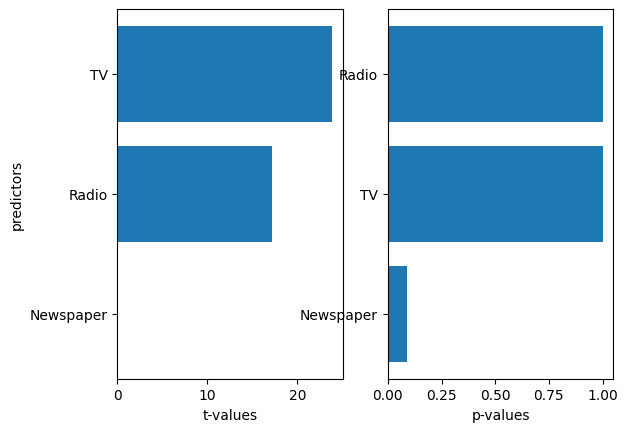

In [9]:
# from coef dist, calculate t stats


coefficient_t_stats = tstat(coef_dist)
predictor_tval_dict = dict(zip(df.columns[:-1], coefficient_t_stats))

predictors0, tvals = list(zip(*sorted(predictor_tval_dict.items(), key=lambda x: x[1])))

# calculate p values
pval = stats.t.sf(coefficient_t_stats, n-1) * 2
conf = 1 - pval

predictor_pval_dict = dict(zip(df.columns[:-1], conf))

predictors1, conf = list(zip(*sorted(predictor_pval_dict.items(), key= lambda x: x[1])))

fig, ax = plt.subplots(1,2)

ax[0].barh(predictors0, tvals)
ax[0].set_xlabel('t-values')
ax[0].set_ylabel('predictors')

ax[1].barh(predictors1, conf)
ax[1].set_xlabel('p-values')

print(conf)
print(coefficient_t_stats)

In [10]:
# plot a contour plot between newspaper and radio

# create a meshgrib of beta values for newspaper and radio

# before we do anythng, we should fit a lreg to find a good b_value,
# as well as b1 and b2 values to center our contour plot around

X = df.drop(['Sales', 'TV'], axis=1)
y = df['Sales']


lreg = LinearRegression().fit(X, y)
lreg.coef_

b1, b2 = lreg.coef_

mult = 3

b1s = np.linspace(-mult*b1, mult*b1, 100)
b2s = np.linspace(-mult*b1, mult*b1, 100)

b1v, b2v = np.meshgrid(b1s,b2s)

print(lreg.coef_)
print(X.columns)

[9.87261186 0.75544264]
Index(['Radio', 'Newspaper'], dtype='object')


Text(0, 0.5, 'Newspaper')

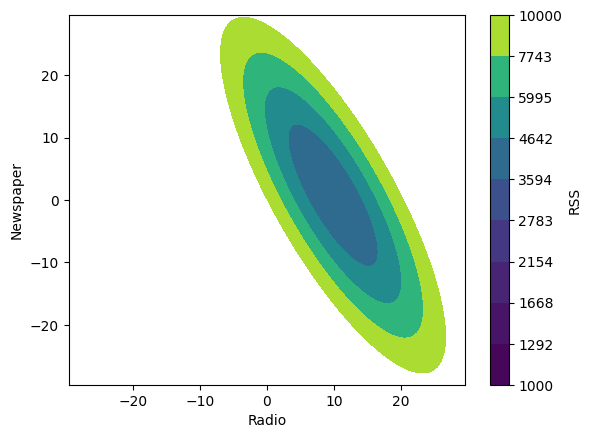

In [11]:
# for the betas, calculate the RSS as newspaper and radio vary
# the intercept will need to be kept the same

# sales_pred = b_0 + b_1 * newspaper + b_2 * radio
# rss = sum( (y - y_pred) ** 2) )
b_0 = lreg.intercept_
rssv = []

for i in range(b1v.shape[0]):
    for j in range(b1v.shape[1]):
        y_pred = b_0 + b1v[i][j] * X['Radio'] + b2v[i][j] * X['Newspaper']
        rssv.append(np.sum((y - y_pred) ** 2))

rssv = np.array(rssv)
plt.contourf(b1v, b2v, rssv.reshape(b1v.shape), levels = np.logspace(start=3,
                                                                     stop=4,
                                                                     base=10,
                                                                     num=10))
plt.colorbar(label="RSS")
plt.xlabel("Radio")
plt.ylabel("Newspaper")